In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from rsradia.magnets import dipole as dipole_module
# import uti_plot
import ipywidgets
from jupyter_rs_radia import radia_viewer
import radia as rad

# Make Dipole
Create a simplified H-type dipole and show several plots of the fields and field quality

In [24]:
# All distances in millimeters
pole_dimensions = {
    'pole_width': 180.,
    'pole_separation': 25.,
    'pole_height': 100.,
    'top_height': 100.,
    'gap_height': 76.5 / 2.,
    'leg_width': 50.
}

dipole_x_center = 0.0
dipole_x_length = 435.0  


angle_min, area_max = 0.005, 500.0

In [37]:
dipole = dipole_module.make_dipole(pole_dimensions, dipole_x_center, dipole_x_length, 
                                   trimesh_mode=0, triangle_min_size=angle_min, triangle_max_size=area_max,
                                   longitudinal_divisions=20, current=-2.1e3 / ((0.75 * pole_dimensions['pole_height']) * (0.85 * pole_dimensions['pole_separation'] - 0.1)))

In [38]:
rv = radia_viewer.RadiaViewer()
rv.add_geometry('Pole', dipole)

In [39]:
rv.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

# Magnet Analysis

### Hit solve in Viewer before running

In [48]:
# IM = rad.RlxPre(dipole)
# res = rad.RlxAuto(IM, 0.001, 1000)

In [60]:
# On Axis field profile
xp = np.linspace(-350, 350, 256)
mesh = np.stack([xp, np.zeros_like(xp).ravel(), np.zeros_like(xp).ravel()]).T

In [61]:
mesh = [list(m) for m in mesh]

In [62]:
Bz_on_mesh = rad.Fld(dipole, 'Bz', mesh)
Bz0 = rad.Fld(dipole, 'Bz', [0, 0, 0])

In [63]:
# Field at center of magnet
Bz0

-0.07142499286366548

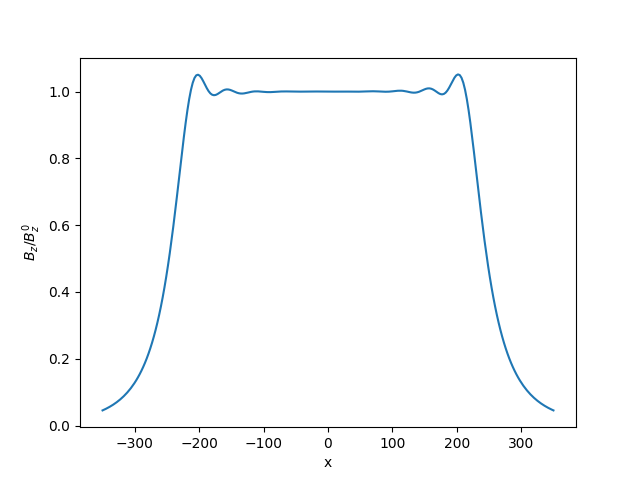

In [64]:
plt.figure()
plt.plot(xp, np.array(Bz_on_mesh) / Bz0)
plt.xlabel('x')
plt.ylabel('$B_z / B_z^0$')
plt.show()

### Y/Z slice at X = 0 

Plot $Bz$ on a grid in YZ in the center of the dipole a $x=0$. This meshed data can then be used to calculate the 'good field region' (GFR) that is the region in YZ where $B_z(y, z) - B_{target} < tolerance$ for some tolerance. Here we just assume the the target B field is Bz at x,y,z = 0. 

In [65]:
Y, Z = np.meshgrid(np.linspace(-pole_dimensions['pole_width'], pole_dimensions['pole_width'], 100),
                   np.linspace(-pole_dimensions['gap_height'], pole_dimensions['gap_height'], 100))

In [66]:
mesh = np.stack([np.zeros_like(Y).ravel(), Y.ravel(), Z.ravel()]).T

In [67]:
mesh = [list(m) for m in mesh]

In [68]:
Bz_on_mesh = rad.Fld(dipole, 'Bz', mesh)
Bz0 = rad.Fld(dipole, 'Bz', [0, 0, 0])

### Plot Bz on Mesh

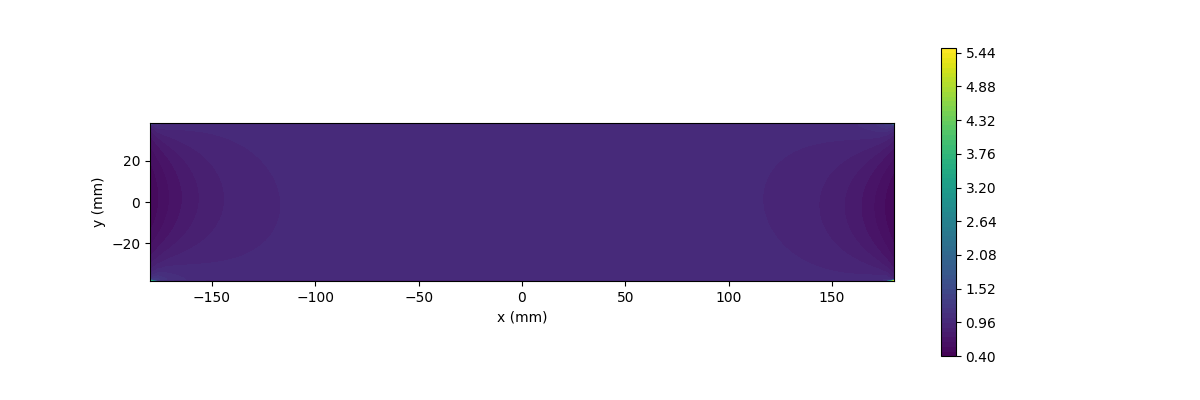

In [69]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
ax.set_aspect('equal')
ct = ax.contourf(Y, Z, np.array(Bz_on_mesh).reshape(*Y.shape) / Bz0, levels=64)
# ax.contour(Y, Z, np.array(Bz_on_mesh).reshape(*Y.shape) / Bz0, levels=[0.5, 1.0, 1.25], colors='r')
plt.colorbar(ct)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

plt.show()

### Setup and plot GFR on Mesh

In [70]:
def gfr(bz_mesh, bz0, gf_level=10**3):
    return np.abs(np.array(bz_mesh) - bz0) / np.abs(bz0)
    

In [71]:
gf_level = gfr(Bz_on_mesh, Bz0)

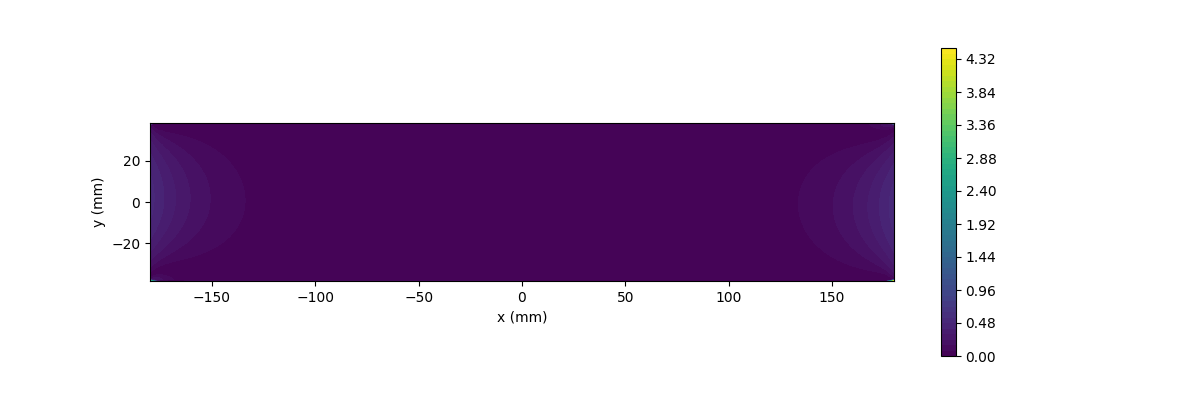

In [72]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
ax.set_aspect('equal')
ct = ax.contourf(Y, Z, gfr(Bz_on_mesh, Bz0).reshape(*Y.shape), levels=64)
plt.colorbar(ct)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

plt.show()

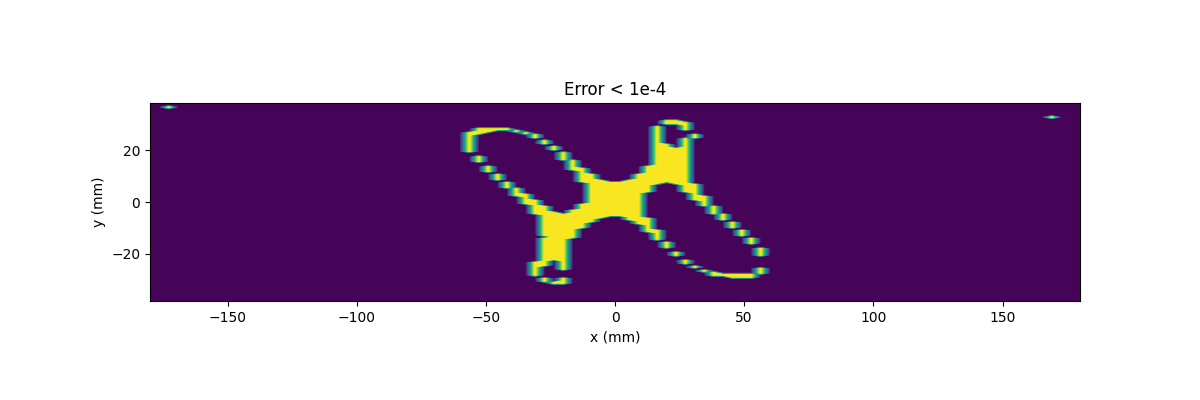

In [73]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ax.set_title("Error < 1e-4")
ax.set_aspect('equal')
ct = ax.contourf(Y, Z, gfr(Bz_on_mesh, Bz0).reshape(*Y.shape) < 1e-4, levels=64)
# plt.colorbar(ct)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

plt.show()

# Integrated Multipole Content

In [74]:
def harm(obj, y, z, R, harmonics, start=-10, end=10, integral_setting = 'inf'):
    arHarm = []
    angles = np.linspace(0, 2 * np.pi, harmonics, endpoint=False)
    for angle in angles:
        cosTet = np.cos(angle)
        sinTet = np.sin(angle)
        re = rad.FldInt(obj, integral_setting, 'ibz', [start, y + R * cosTet, z + R * sinTet],
                        [end, y + R * cosTet, z + R * sinTet])
        im = rad.FldInt(obj, integral_setting, 'iby', [start, y + R * cosTet, z + R * sinTet],
                        [end, y + R * cosTet, z + R * sinTet])
        arHarm.append(complex(re, im))
    return arHarm


def multipole(arHarm, R, n):
    s = 0
    nharm = len(arHarm)
    for i, harm in enumerate(arHarm):
        arg = -2 * np.pi / nharm * n * i
        s += harm * complex(np.cos(arg), np.sin(arg))
    return s / nharm / (R ** n)

In [75]:
# harmonic analysis of the field integrals
nharm = 8; radius = 0.25; y = 0; z = 0;
w = harm(dipole, y, z, radius, nharm);

mm = [multipole(w, radius, i) for i in range(nharm)];
round_mm = [complex(round(mm[i].real, 9), round(mm[i].imag, 9)) for i in range(nharm)];

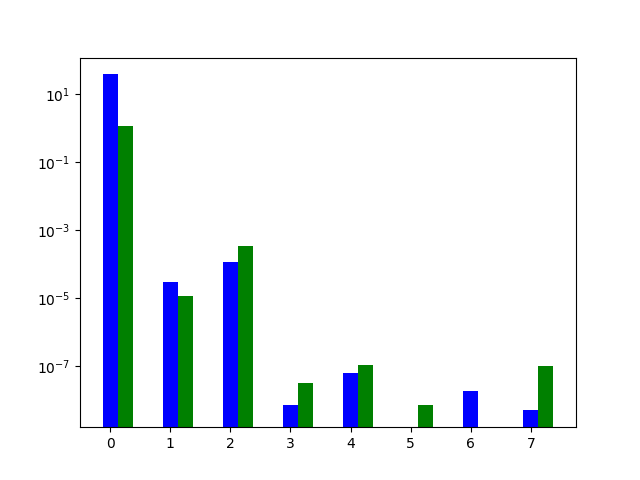

In [76]:
X = np.arange(nharm)
fig, ax = plt.subplots()
re_comp = [ harms.real for harms in round_mm]
im_comp = [ harms.imag for harms in round_mm]
ax.bar(X + 0.00, np.abs(re_comp), color = 'b', width = 0.25)
ax.bar(X + 0.25, np.abs(im_comp), color = 'g', width = 0.25)
ax.set_yscale('log')